# Recommendation Techniques and Results

In this file, using merged data of game and player we develop the working recommendation system

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from scipy.spatial import distance

from sklearn.manifold import TSNE
from gensim.models.keyedvectors import Word2VecKeyedVectors
import textwrap

from support_function import *

#Import Warnings
import warnings
warnings.filterwarnings("ignore")

Load the supported function from support_function.py file in this notebook.

In [49]:
%run support_function.py

## Get the Data For recommendation from cvs file.

We load the csv file which contain the userId and game id in it.

In [50]:
user_recom_data = pd.read_csv('recdata.csv', index_col=0)
user_recom_data = user_recom_data.rename(columns = {'variable':'id', 'value': 'owned'})
user_recom_data.head()

,uid,id,owned
0,0,10,1.0
1,1,10,1.0
2,3,10,1.0
3,4,10,1.0
4,10,10,1.0


We load the games data with names and all other information like geners

In [51]:
# Load games data
game_recom_data = pd.read_csv('gamesdata.csv', index_col = 0)
game_recom_data.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


## Additional Preprocessing

### Create interaction matrix

We will create an interactions matrix using the user-item data. This is done using the `create_interaction_matrix` function, which can be found in `support_function.py`.

In [52]:
inter_mat = build_matrix(data_frame= user_recom_data,
                                         u_column = 'uid',
                                         i_column = 'id',
                                         r_column = 'owned')
inter_mat.shape

(8769, 8171)

From the shape, we note that we have 8769 unique users and 8171 different games represented.

In [53]:
# Preview head
inter_mat.head(10)

id,10,20,30,40,50,60,70,80,130,220,...,525190,526460,526790,527340,527440,527510,527520,527810,527900,530720
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Break Down the dataset into train and test

In [54]:
# Get number of users
len(inter_mat)

8769

We choose to have roughly 80% of our data as training and 20% as test.

In [55]:
# Establish number of users in train/test sets

train_num = round((80/100)*len(inter_mat),0)
print(f'We desire {train_num} users in our training set.')

test_num = len(inter_mat)-train_num
print(f'We desire {test_num} users in our test set.')

We desire 7015.0 users in our training set.
We desire 1754.0 users in our test set.


In [56]:
# Define train and test sets
train = inter_mat[:7015]
test = inter_mat[7015:]

### Build Player Dictionary

In [57]:
# Create user dictionary using helper function
player_dic = build_dic_user(matrix_inter=inter_mat)

### Build Game Dictionary

In [59]:
# Create game dictionary using helper function
dic_game = build_dic_item(data_frame=game_recom_data, column_id= 'id', column_n='title')

### Build Sparse Matrix

We will transform the interaction into a sparse matrix, to make computations efficient.

For the trainset, we simply use the `sparse.csr_matrix()` function.

With the test set, due to a known issue, we need to add additional rows so that the number of rows matches the trains set.

In [12]:
# Create sparse matrices for evaluation 
train_sparse = sparse.csr_matrix(train.values)

#Add X users to Test so that the number of rows in Train match Test
N = train.shape[0] #Rows in Train set
n,m = test.shape #Rows & columns in Test set
z = np.zeros([(N-n),m]) #Create the necessary rows of zeros with m columns
#test = test.toarray() #Temporarily convert Test into a numpy array
test = np.vstack((test,z)) #Vertically stack Test on top of the blank users
test_sparse = sparse.csr_matrix(test) #Convert back to sparse

## Using Hybrid Model LightFM for the Recommendation

### Input WARP loss model

In [14]:
mf_model_warp = apply_model(matrix_inter= train,
                 component_val= 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [15]:
train_precision = precision_at_k(mf_model_warp, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.73, test 0.43.


In [16]:
train_auc = auc_score(mf_model_warp, train_sparse).mean()
test_auc = auc_score(mf_model_warp, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.92.


AUC score is very good on both train and test

### Input BPR loss model

In [17]:
mf_model_bpr = apply_model(matrix_inter= train,
                 component_val= 30,
                 loss = 'bpr',
                 epoch = 30,
                 n_jobs = 4)

In [18]:
train_precision = precision_at_k(mf_model_bpr, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_bpr, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.80, test 0.36.


In [19]:
train_auc = auc_score(mf_model_bpr, train_sparse).mean()
test_auc = auc_score(mf_model_bpr, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.96, test 0.71.


Again, the AUC score is good, though significantly lower for the test set compare to the train set.

Based on these two models, we will keep WARP as the loss function due to better performance all round.

### Hyper Tuning of the model by varing components

The `n_components` parameter controlls the number of embeddings (dimension of the features in the latent space.)

We will vary this number, lowering it to `10` first and then increasing it to `50` to see how this affects model performance.

In [20]:
mf_model_warp_2 = apply_model(matrix_inter= train,
                 component_val= 10,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [21]:
train_precision = precision_at_k(mf_model_warp_2, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_2, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.68, test 0.48.


In [22]:
train_auc = auc_score(mf_model_warp_2, train_sparse).mean()
test_auc = auc_score(mf_model_warp_2, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.97, test 0.93.


In [23]:
mf_model_warp_50 = apply_model(matrix_inter= train,
                 component_val= 50,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [24]:
train_precision = precision_at_k(mf_model_warp_50, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_50, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.76, test 0.42.


In [25]:
train_auc = auc_score(mf_model_warp_50, train_sparse).mean()
test_auc = auc_score(mf_model_warp_50, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.99, test 0.91.


In the end performance is not change on the base of component

### Build Model

In [13]:
# Instantiate and fit model on full interactions set
light_fm_mode = apply_model(matrix_inter= inter_mat,
                 component_val = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

## Embeddings

Apply Embedding Space of the Model

### Retrieve embeddings matrix

In [14]:
# Get embeddings
embeddings = light_fm_mode.item_embeddings
embeddings

array([[-0.07690857,  0.66486156,  0.7936622 , ...,  0.14951605,
        -0.0695671 , -0.6245182 ],
       [-0.60291576,  0.83658946,  0.58764905, ...,  0.5114703 ,
        -0.3604954 , -1.0809734 ],
       [-0.2310924 ,  1.0992005 ,  0.64228845, ...,  0.98967004,
         0.06214582, -0.49858683],
       ...,
       [ 0.64778465, -0.10613031,  0.09715862, ...,  0.57438576,
        -0.2034148 , -0.07921824],
       [ 0.27167612,  0.5803558 , -0.41966903, ...,  0.6099575 ,
         0.5862158 , -0.12392855],
       [ 0.35757646,  0.32205895, -0.3167676 , ...,  0.53355885,
         0.01019462,  0.25211778]], dtype=float32)

In [15]:
embeddings.shape

(8171, 30)

Check the Game Vector

In [16]:
embeddings[0]

array([-0.07690857,  0.66486156,  0.7936622 ,  0.40528223, -0.145565  ,
       -0.36309764, -0.34237215,  0.15373814,  0.54323393, -0.5631929 ,
       -0.61242783, -0.29522717,  0.5400072 ,  0.34600753, -0.74698734,
       -0.2089371 ,  0.31638432, -0.23969008, -0.64567953, -0.39736956,
        0.1493338 ,  0.21329583,  0.7203192 , -0.6489853 , -0.0677067 ,
       -0.31437442,  0.27613798,  0.14951605, -0.0695671 , -0.6245182 ],
      dtype=float32)

Find the game name from the matrix

In [17]:
firstgameid = inter_mat.columns[0]
dic_game[firstgameid]

'Counter-Strike'

### Pair similarity

Let find the distance between the similar game

We search the 'Counter-Strike' game

In [18]:
game_recom_data[(game_recom_data['title']=='Counter-Strike') | (game_recom_data['title']=='Left 4 Dead 2') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31529,Valve,['Action'],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Ac...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"['Single-player', 'Multi-player', 'Co-op', 'St...",19.99,False,550.0,Valve,Overwhelmingly Positive,89.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


Check the Vector of the games

In [19]:
cs_index = 0
cs_vector = embeddings[cs_index]
cs_vector

array([-0.07690857,  0.66486156,  0.7936622 ,  0.40528223, -0.145565  ,
       -0.36309764, -0.34237215,  0.15373814,  0.54323393, -0.5631929 ,
       -0.61242783, -0.29522717,  0.5400072 ,  0.34600753, -0.74698734,
       -0.2089371 ,  0.31638432, -0.23969008, -0.64567953, -0.39736956,
        0.1493338 ,  0.21329583,  0.7203192 , -0.6489853 , -0.0677067 ,
       -0.31437442,  0.27613798,  0.14951605, -0.0695671 , -0.6245182 ],
      dtype=float32)

In [20]:
lfd2_id = game_recom_data[game_recom_data['title']=='Left 4 Dead 2']['id'].values[0]
lfd2_index = list(inter_mat.columns).index(lfd2_id)
lfd2_vector = embeddings[lfd2_index]
lfd2_vector

array([-0.01273242, -0.07405546,  0.6101665 ,  0.1412955 , -0.330248  ,
       -0.9404025 , -0.29786164, -0.25623107,  0.19409557,  0.40056136,
       -0.60454905,  0.01597847,  0.29765967,  1.0109664 , -0.6728011 ,
        0.5028252 , -0.14399414, -0.2512675 , -0.32039464, -0.43069765,
        0.16283731,  0.60680556,  0.1759727 , -0.2787006 , -0.5939248 ,
        0.5459706 ,  0.28189695, -0.43314165, -0.60124415, -0.62766606],
      dtype=float32)

To assign a single value to the similarity between these two vectors, we calculate the distance between them. Let us first compute the Euclidean distance.

In [21]:
# Compute Euclidean distance
distance.euclidean(cs_vector, lfd2_vector)

2.4286489486694336

Let us compare this figure with a pair of games we believe to be very different.

In [22]:
# Get data for both games
game_recom_data[(game_recom_data['title']=='Counter-Strike') | (game_recom_data['title']=='The Room') ]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
2472,Fireproof Games,"['Adventure', 'Indie']",The Room,The Room,http://store.steampowered.com/app/288160/The_R...,2014-07-28,"['Puzzle', 'Adventure', 'Point & Click', 'Indi...",NaN,http://steamcommunity.com/app/288160/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,288160.0,Fireproof Games,Overwhelmingly Positive,73.0
32106,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [23]:
# Retrieve game id for The Room
room_id = game_recom_data[game_recom_data['title']=='The Room']['id'].values[0]

# Obtain index for Squad in interactions matrix
room_index = list(inter_mat.columns).index(room_id)

# Obtain embeddings vector
room_vector = embeddings[room_index]

room_vector

array([-0.1024242 ,  0.4752257 ,  0.24124612, -0.00741749,  0.21419159,
       -0.28054076, -0.03180434, -0.38254467,  0.13352183, -0.33322603,
        0.13092154, -0.15414314,  0.00489135, -0.19807154, -0.33829376,
       -0.07191804, -0.17468366,  0.18996401,  0.08875996,  0.30820638,
        0.35630605,  0.00255273, -0.5786068 ,  0.22534879,  0.0135782 ,
       -0.45574978, -0.27468544, -0.31314114, -0.21707602, -0.04487913],
      dtype=float32)

In [24]:
# Compute Euclidean distance
distance.euclidean(cs_vector, room_vector)

2.738154172897339

Check the distance with cosine distance

In [25]:
print(f'Cosine distance between Counter Strike and Left 4 Dead 2: {distance.cosine(cs_vector, lfd2_vector)}')
print(f'Cosine distance between Counter Strike and The Room: {distance.cosine(cs_vector, room_vector)}')

Cosine distance between Counter Strike and Left 4 Dead 2: 0.4738824963569641
Cosine distance between Counter Strike and The Room: 0.9319570809602737


### Exploring embeddings with Gensim

In [26]:
embedding_size = embeddings.shape[1]
kv = Word2VecKeyedVectors(embedding_size)

gameslist = []
for game_id in inter_mat.columns:
    name = dic_game[game_id]
    gameslist.append(name)
    
kv.add_vectors(gameslist, embeddings)

Let us obtain the games closest to `Counter-Strike`.

In [27]:
kv.most_similar('Counter-Strike')

[('Counter-Strike: Condition Zero', 0.9755569100379944),
 ('Day of Defeat', 0.8177651762962341),
 ('Half-Life: Source', 0.8058030009269714),
 ('Day of Defeat: Source', 0.8011133074760437),
 ('Team Fortress Classic', 0.7981202006340027),
 ('Half-Life: Blue Shift', 0.7888646721839905),
 ('Half-Life', 0.7878614068031311),
 ('Ricochet', 0.7845215797424316),
 ('Deathmatch Classic', 0.7804338335990906),
 ('Half-Life: Opposing Force', 0.7775993347167969)]

In [41]:
kv.most_similar('Left 4 Dead 2')

[('PAYDAY™ The Heist', 0.9239243865013123),
 ('Borderlands 2', 0.8823978900909424),
 ("Garry's Mod", 0.8753825426101685),
 ('Counter-Strike: Global Offensive', 0.8716615438461304),
 ('Killing Floor', 0.8585674166679382),
 ('Defence Alliance 2', 0.8505985140800476),
 ('The Ship: Murder Party', 0.842189610004425),
 ('Saints Row IV', 0.8398149609565735),
 ('Terraria', 0.8383126854896545),
 ('Chivalry: Medieval Warfare', 0.8292756676673889)]

In [28]:
def build_graph(game, x, best_num=5):
    sim = kv.most_similar(game, topn=best_num)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    x.barh(y, w)
    left = min(.6, min(w))
    x.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    x.set_yticks(y)
    x.set_yticklabels(labels)
    x.set_title(game)   

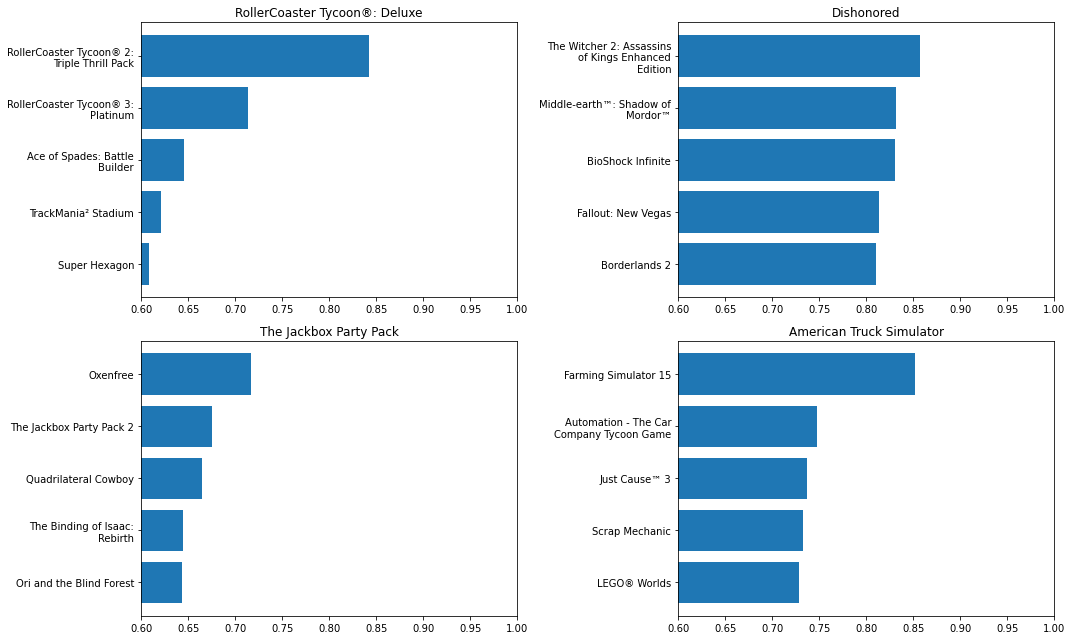

In [29]:
list_game = ['RollerCoaster Tycoon®: Deluxe', 'Dishonored', 
         'The Jackbox Party Pack', 'American Truck Simulator']

figure, ax = plt.subplots(2, 2, figsize=(15, 9))

for game, ax in zip(list_game, ax.flatten()):
    build_graph(game, ax)
    
figure.tight_layout()

## User Recommendations

### Recommendations for existing user

In [31]:
# Get recommendations
rec_list_u12 = find_recom(rec_mode= light_fm_mode, 
                    matrix_inter= inter_mat, 
                    player_id= 5000, 
                    dic_player= player_dic,
                    dic_game= dic_game, 
                    threshold = 0,
                    num_items = 5,
                    show_known = True, 
                    show_recs = True)

Games Likes:
1- Dungeon Fighter Online
2- ESEA
3- H1Z1 Test Server
4- H1Z1
5- CS:GO Player Profiles
6- Just Survive Test Server
7- AdVenture Capitalist
8- Strife®
9- Dirty Bomb®
10- Game of Thrones - A Telltale Games Series
11- Don't Starve Together
12- Unturned
13- Robocraft
14- Mount Your Friends
15- Warface
16- Fistful of Frags
17- The Walking Dead: Season 2
18- Rust
19- Toribash
20- Heroes &amp; Generals
21- FEZ
22- No More Room in Hell
23- Cry of Fear
24- Insurgency
25- Hotline Miami
26- MapleStory
27- The Walking Dead
28- Castle Crashers®
29- Max Payne 3
30- Mount &amp; Blade: Warband
31- Super Meat Boy
32- Defence Alliance 2
33- TrackMania Nations Forever
34- BioShock Infinite
35- Just Cause 2
36- Garry's Mod
37- Killing Floor
38- Counter-Strike: Global Offensive
39- Left 4 Dead 2
40- Left 4 Dead
41- Half-Life 2: Episode Two
42- Portal
43- Half-Life 2: Episode One
44- Half-Life Deathmatch: Source
45- Half-Life 2: Lost Coast
46- Half-Life 2: Deathmatch
47- Counter-Strike: Source


## Item Recommendations

### Create item embedding matrix

In [32]:
game_mat_data =  build_embedding_mat(rec_mode=light_fm_mode, matrix_inter=inter_mat)

In [33]:
game_mat_data.shape

(8171, 8171)

In [34]:
game_mat_data.head()

id,10,20,30,40,50,60,70,80,130,220,...,525190,526460,526790,527340,527440,527510,527520,527810,527900,530720
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.798120,0.817765,0.780434,0.777599,0.784522,0.787861,0.975557,0.788865,0.720709,...,-0.306754,-0.330438,-0.341211,-0.054234,-0.361544,-0.485556,-0.328589,-0.066259,-0.281063,-0.482814
20,0.798120,1.000000,0.867307,0.852161,0.994024,0.866077,0.977754,0.699381,0.995552,0.846169,...,-0.293373,-0.205190,-0.240755,-0.133135,-0.242896,-0.352428,-0.174543,-0.130799,-0.206378,-0.334659
30,0.817765,0.867307,1.000000,0.990534,0.862059,0.990114,0.843498,0.719655,0.871238,0.718637,...,-0.162556,-0.096175,-0.150723,-0.181699,-0.069702,-0.258437,-0.061448,0.054523,-0.009513,-0.191741
40,0.780434,0.852161,0.990534,1.000000,0.849804,0.994848,0.820985,0.670797,0.858557,0.672284,...,-0.095033,-0.022256,-0.077084,-0.152839,-0.026975,-0.190437,0.011434,0.098432,0.068500,-0.126358
50,0.777599,0.994024,0.862059,0.849804,1.000000,0.862647,0.981975,0.675560,0.996402,0.849154,...,-0.301745,-0.195885,-0.240017,-0.145447,-0.224202,-0.325862,-0.143163,-0.115081,-0.192277,-0.309017


### Generate item recommendations

In [37]:
item_rec_list_10 = return_recomm( embedd_mat= game_mat_data, 
                              game_id= 10, 
                              dic_game= dic_game, 
                              n_items = 6, 
                              show = True)

Item of interest: Counter-Strike
Similar items:
1- Counter-Strike: Condition Zero
2- Day of Defeat
3- Half-Life: Source
4- Day of Defeat: Source
5- Team Fortress Classic
6- Half-Life: Blue Shift


In [62]:
game_recom_data[game_recom_data['title'] == 'The Witness']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5211,"Thekla, Inc.","['Adventure', 'Indie']",The Witness,The Witness,http://store.steampowered.com/app/210970/The_W...,2016-01-26,"['Puzzle', 'Exploration', 'First-Person', 'Sin...",NaN,http://steamcommunity.com/app/210970/reviews/?...,"['Single-player', 'Steam Achievements', 'Capti...",39.99,False,210970.0,"Thekla, Inc.",Very Positive,87.0


In [63]:
game_210970 = return_recomm( embedd_mat= game_mat_data, 
                              game_id = 210970, 
                              dic_game= dic_game, 
                              n_items = 5, 
                              show = True)

Item of interest: The Witness
Similar items:
1- Bear Simulator
2- Everybody's Gone to the Rapture
3- OPUS: The Day We Found Earth
4- ABZU
5- Dangerous Golf


In [60]:
game_recom_data[game_recom_data['title'] == 'ABZU']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
22123,505 Games,"['Action', 'Adventure', 'Casual', 'Indie', 'Si...",ABZU,ABZU,http://store.steampowered.com/app/384190/ABZU/,2016-08-02,"['Relaxing', 'Atmospheric', 'Underwater', 'Gre...",NaN,http://steamcommunity.com/app/384190/reviews/?...,"['Single-player', 'Steam Achievements', 'Full ...",19.99,False,384190.0,Giant Squid,Very Positive,83.0


In [64]:
game_384190 = return_recomm( embedd_mat= game_mat_data, 
                              game_id = 384190, 
                              dic_game= dic_game, 
                              n_items = 6, 
                              show = True)

Item of interest: ABZU
Similar items:
1- Quadrilateral Cowboy
2- The Witness
3- Valley
4- Replica
5- 1979 Revolution: Black Friday
6- Everybody's Gone to the Rapture
